In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
file_path = "dirty_cafe_sales.csv"
df = pd.read_csv(file_path)

# Display Basic info
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


,0
Transaction ID,0
Item,333
Quantity,138
Price Per Unit,179
Total Spent,173
Payment Method,2579
Location,3265
Transaction Date,159


In [ ]:
# % of missing data
df.isnull().sum()/df.shape[0]*100

,0
Transaction ID,0.00
Item,3.33
Quantity,1.38
Price Per Unit,1.79
Total Spent,1.73
Payment Method,25.79
Location,32.65
Transaction Date,1.59


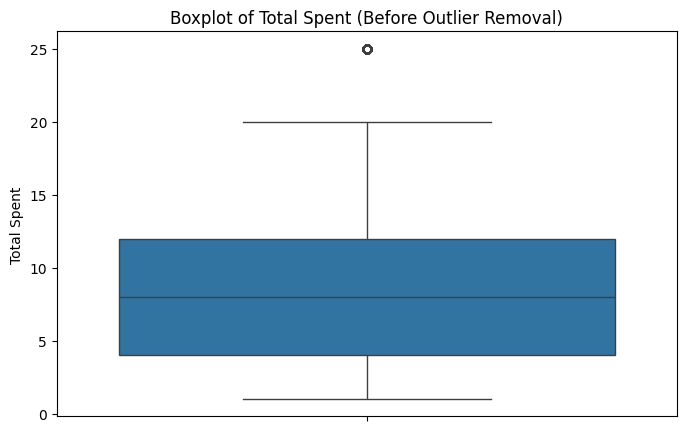

In [ ]:
# Convert relevant columns to numeric, handling errors
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')

# Fill missing values
df[['Quantity', 'Price Per Unit', 'Total Spent']] = df[['Quantity', 'Price Per Unit', 'Total Spent']].fillna(df[['Quantity', 'Price Per Unit', 'Total Spent']].median())

# Boxplot before outlier removal
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['Total Spent'])
plt.title("Boxplot of Total Spent (Before Outlier Removal)")
plt.show()


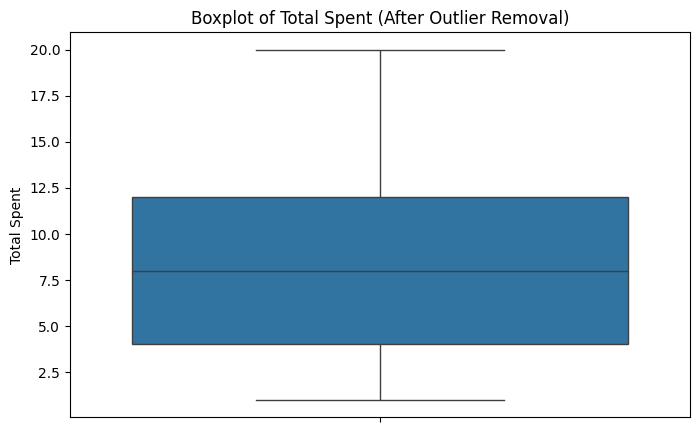

In [ ]:
# Outlier detection and removal using IQR
Q1 = df['Total Spent'].quantile(0.25)
Q3 = df['Total Spent'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df = df[(df['Total Spent'] >= lower_bound) & (df['Total Spent'] <= upper_bound)]

# Boxplot after outlier removal
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['Total Spent'])
plt.title("Boxplot of Total Spent (After Outlier Removal)")
plt.show()


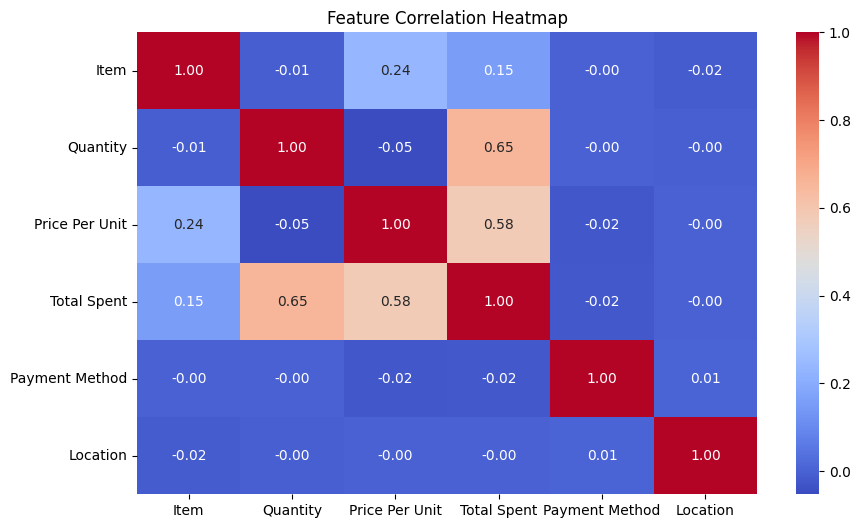

In [ ]:
# Encode categorical variables
encoder = LabelEncoder()
for col in ['Item', 'Payment Method', 'Location']:
    df[col] = encoder.fit_transform(df[col].fillna('Unknown'))

# Drop unnecessary columns
df.drop(columns=['Transaction ID', 'Transaction Date'], inplace=True, errors='ignore')

# Heatmap for feature correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Regression: Predict Total Spent
X_reg = df.drop(columns=['Total Spent'])
y_reg = df['Total Spent']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train regression models
reg_rf = RandomForestRegressor().fit(X_train_r, y_train_r)
reg_xgb = XGBRegressor().fit(X_train_r, y_train_r)
reg_gb = GradientBoostingRegressor().fit(X_train_r, y_train_r)

# Evaluate regression models
def evaluate_model(name, y_test, y_pred):
    print(f"{name} MAE:", mean_absolute_error(y_test, y_pred))
    print(f"{name} RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print(f"{name} R² Score:", r2_score(y_test, y_pred))
    print("")

y_pred_rf_r = reg_rf.predict(X_test_r)
y_pred_xgb_r = reg_xgb.predict(X_test_r)
y_pred_gb_r = reg_gb.predict(X_test_r)

evaluate_model("Random Forest", y_test_r, y_pred_rf_r)
evaluate_model("XGBoost", y_test_r, y_pred_xgb_r)
evaluate_model("Gradient Boosting", y_test_r, y_pred_gb_r)

Random Forest MAE: 0.6770361863591885
Random Forest RMSE: 1.6661596152417073
Random Forest R² Score: 0.89692203462225

XGBoost MAE: 0.68894591019238
XGBoost RMSE: 1.624596668998178
XGBoost R² Score: 0.9020005254795057

Gradient Boosting MAE: 0.6667823006760543
Gradient Boosting RMSE: 1.5624270720354991
Gradient Boosting R² Score: 0.9093574445846153



<ipython-input-14-4c37b36c7495>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=metrics_df, ax=ax[0], palette="viridis")
<ipython-input-14-4c37b36c7495>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R² Score', data=metrics_df, ax=ax[1], palette="coolwarm")


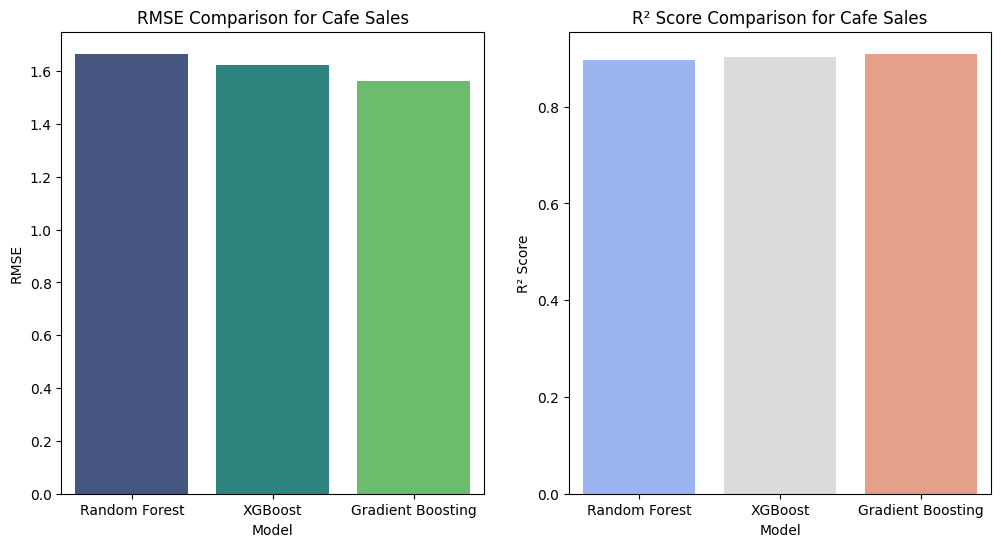

In [ ]:
# Visualizing model performance
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_xgb_r)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_gb_r))
    ],
    'R² Score': [
        r2_score(y_test_r, y_pred_rf_r),
        r2_score(y_test_r, y_pred_xgb_r),
        r2_score(y_test_r, y_pred_gb_r)
    ]
})

fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.barplot(x='Model', y='RMSE', data=metrics_df, ax=ax[0], palette="viridis")
ax[0].set_title("RMSE Comparison for Cafe Sales")
sns.barplot(x='Model', y='R² Score', data=metrics_df, ax=ax[1], palette="coolwarm")
ax[1].set_title("R² Score Comparison for Cafe Sales")
plt.show()

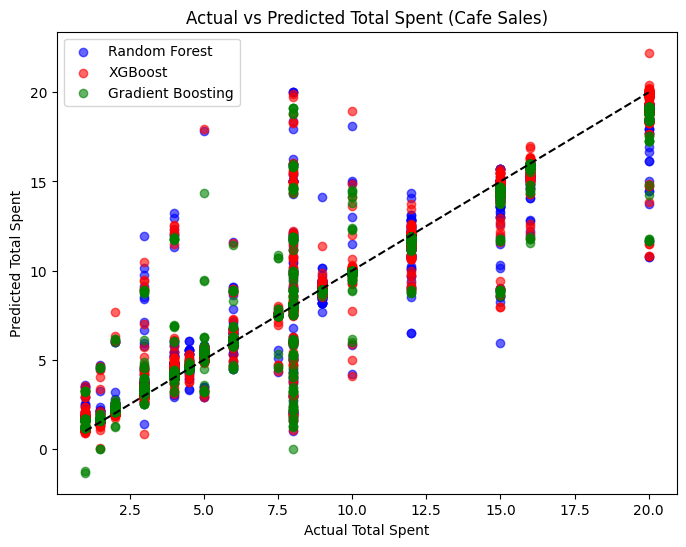

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test_r, y_pred_rf_r, label="Random Forest", alpha=0.6, color='blue')
plt.scatter(y_test_r, y_pred_xgb_r, label="XGBoost", alpha=0.6, color='red')
plt.scatter(y_test_r, y_pred_gb_r, label="Gradient Boosting", alpha=0.6, color='green')
plt.plot([min(y_test_r), max(y_test_r)], [min(y_test_r), max(y_test_r)], '--', color='black')
plt.xlabel("Actual Total Spent")
plt.ylabel("Predicted Total Spent")
plt.legend()
plt.title("Actual vs Predicted Total Spent (Cafe Sales)")
plt.show()